# Importing Libraries

In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dense, Dropout
from nltk.translate.bleu_score import corpus_bleu
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Mounting the colab with drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
project_path = '/content/drive/MyDrive/DeepLearingProject '

zip_img_path = f"{project_path}/Images.zip"
txt_cap_path = f"{project_path}/captions.txt"

# img extracted will be at
extract_folders = '/content/imgs'


# unzip the Image folder

In [6]:
import zipfile

with zipfile.ZipFile(zip_img_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folders)

print("Imges are extracted to: ", extract_folders)

Imges are extracted to:  /content/imgs


# Custom Build CNN layer

In [7]:
def custom_cnn_model():
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))

    # Block 2
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))

    # Block 3
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))

    # Block 4
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))

    # Block 5
    model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    # output -> (512,1)
    model.add(GlobalAveragePooling2D())

    # Dense layers - 4096 dimensions
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))

    return model

# cnn model
model = custom_cnn_model()

# summarize
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │     4,198,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,296,256 (24.02 MB)

 Trainable params: 6,294,272 (24.01 MB)

 Non-trainable params: 1,984 (7.75 KB)

None


# Feature Extraction

In [8]:
# extract features from the image

features = {}
directional = os.path.join(extract_folders, 'Images')

for img_name in tqdm(os.listdir(directional)):
    # load the image from file
    img_path = directional + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image id
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8090 [00:00<?, ?it/s]

In [9]:
# feature store in a file using pickle
with open('/content/fea_reuse.pkl', 'wb') as f:
    pickle.dump(features, f)

print("Features saved to /content/fea_reuse.pkl")


Features saved to /content/fea_reuse.pkl


In [10]:
  #  load the captions data
with open(txt_cap_path, 'r') as f:
    next(f)
    captions_doc = f.read()

In [11]:
# loading the pickel file which stored the dump file
with open('/content/fea_reuse.pkl', 'rb') as f:
    features = pickle.load(f)


In [12]:
# captions_doc having img name and its captions
captions_doc

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1002674143_1b742ab4b8.j

# Preprocess the captions

In [13]:
# create mapping of image to captions
mapping = {}

for line in tqdm(captions_doc.split('\n')):
  # split the line by comma
  tokens = line.split(',')
  if len(line) < 2:
    continue
  image_id, caption = tokens[0], tokens[1]
  # remove extension from img id
  image_id = image_id.split('.')[0]
  # convert caption to lowercase
  caption = "".join(caption)
  # create list needed
  if image_id not in mapping:
    mapping[image_id] = []
  # store the caption
  mapping[image_id].append(caption)


  0%|          | 0/40456 [00:00<?, ?it/s]

In [14]:
# length of the mapping dictionry
len(mapping)

8091

In [30]:
# preprocessed mapping dic
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      # take one caption at a time
      caption = captions[i]
      # preprocess
      caption = caption.lower()
      caption = caption.replace('[^A-Za-z]','')
      caption = caption.replace('\s+',' ')
      # add start and end tags
      caption = 'startseq '+" ".join([word for word in caption.split() if len(word)>1])+ ' endseq'
      captions[i] = caption


In [16]:
# before preprocess of text
mapping['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [17]:
# preprocess the text
clean(mapping)

In [18]:
# cleaned mapping
mapping['1001773457_577c3a7d70']

['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [19]:
# list of captions
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [20]:
# length of list
len(all_captions)

40455

In [21]:
# first 10 captions
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [22]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [23]:
# words size
vocab_size

8313

In [24]:
# get maximum lengt of the captions availale
max_length = max(len(caption.split()) for caption in all_captions)
max_length

31

In [25]:
# train test split

# Total image IDs
image_ids = list(mapping.keys())

# Split 80% train, 10% val, 10% test
train_split = int(len(image_ids) * 0.80)
val_split = int(len(image_ids) * 0.90)

train = image_ids[:train_split]
val = image_ids[train_split:val_split]
test = image_ids[val_split:]

print(f"Train size: {len(train)}")
print(f"Validation size: {len(val)}")
print(f"Test size: {len(test)}")

Train size: 6472
Validation size: 809
Test size: 810


In [26]:
# create data genertor to get data in batch - to avoid session crash
def datagenerator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  # loopover imgs
  X1, X2, y = list(), list(), list()
  n = 0
  while 1:
    for key in data_keys:
      n += 1
      captions = mapping[key]
      # process each caption
      for caption in captions:
        seq = tokenizer.texts_to_sequences([caption])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

          # store the sequences
          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        yield (X1, X2), y
        X1, X2, y = list(), list(), list()
        n = 0

# CNN + LSTM model creation

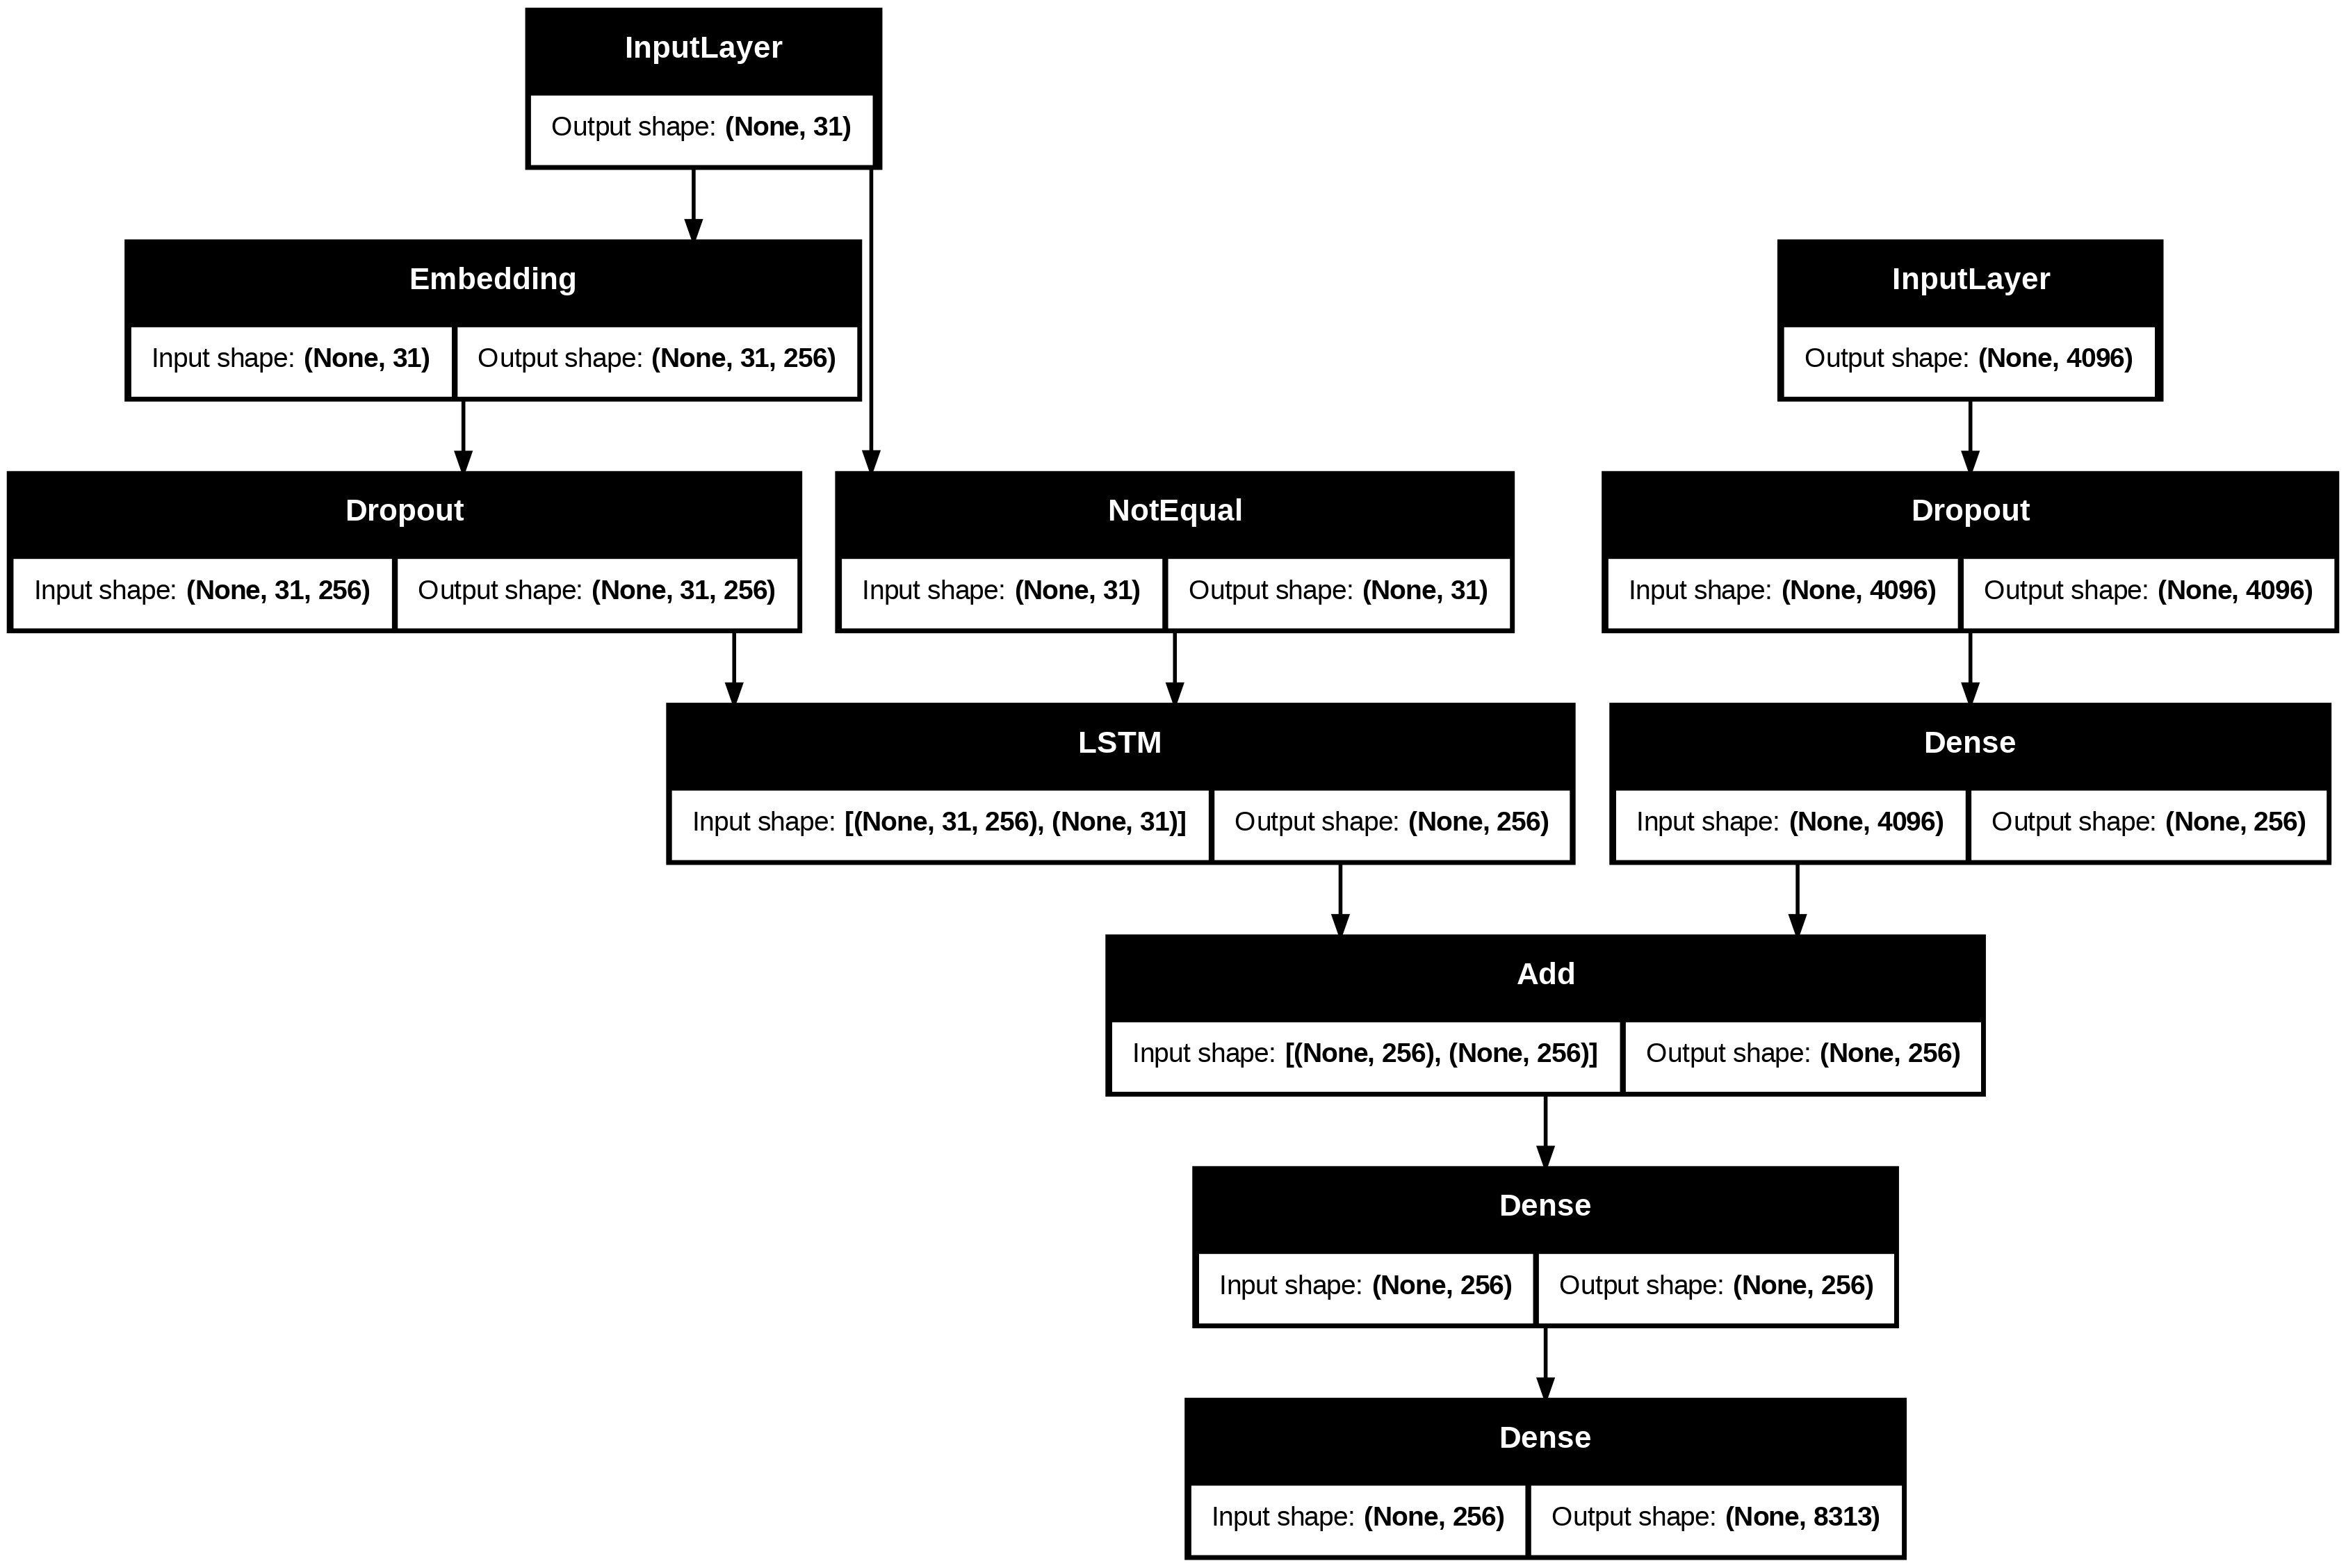

In [27]:
# modelcreation

# encoder model
# img feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# seq fature layers
inputs2 = Input(shape=(max_length,))
seq1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
seq2 = Dropout(0.4)(seq1)
seq3 = LSTM(256, return_sequences=False, recurrent_activation='sigmoid', activation='tanh', unroll=True)(seq2)

# decoder model
decoder1 = add([fe2, seq3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [28]:
# Filter: Keep only image-caption mappings where features exist
mapping = {k: v for k, v in mapping.items() if k in features}

# Filter: Update train list accordingly
train = [img_id for img_id in train if img_id in features]

# Model Train

In [29]:
import matplotlib.pyplot as plt

# Initialize history trackers
full_history = {
    'loss': [],
    'val_loss': []
}

# Training configuration
epochs = 15
batch_size = 64
steps = len(train) // batch_size
val_steps = len(test) // batch_size  # using test set as validation

for i in range(epochs):
    print(f"\nEpoch {i+1}/{epochs}")

    # Create data generators
    generator = datagenerator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    val_generator = datagenerator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size)

    # Train for one epoch
    history = model.fit(
        generator,
        validation_data=val_generator,
        steps_per_epoch=steps,
        validation_steps=val_steps,
        epochs=1,
        verbose=1
    )

    # Store loss values
    full_history['loss'] += history.history.get('loss', [])
    full_history['val_loss'] += history.history.get('val_loss', [])



Epoch 1/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 2259s 22s/step - loss: 6.3141 - val_loss: 5.1746

Epoch 2/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 42s 413ms/step - loss: 4.8925 - val_loss: 4.3845

Epoch 3/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 42s 419ms/step - loss: 4.2172 - val_loss: 4.1427

Epoch 4/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 42s 418ms/step - loss: 3.9504 - val_loss: 4.0342

Epoch 5/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 42s 419ms/step - loss: 3.7871 - val_loss: 3.9652

Epoch 6/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 43s 424ms/step - loss: 3.6630 - val_loss: 3.9347

Epoch 7/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 42s 417ms/step - loss: 3.5705 - val_loss: 3.8988

Epoch 8/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 412ms/step - loss: 3.4856 - val_loss: 3.8882

Epoch 9/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 42s 414ms/step - loss: 3.4143 - val_loss: 3.8786

Epoch 10/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 412ms/step - loss: 3.3465 - val_loss: 3.8902

Epoch 11/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 42s 420ms/step - loss: 3.2884 - val_loss: 3.9135

Epoch 1

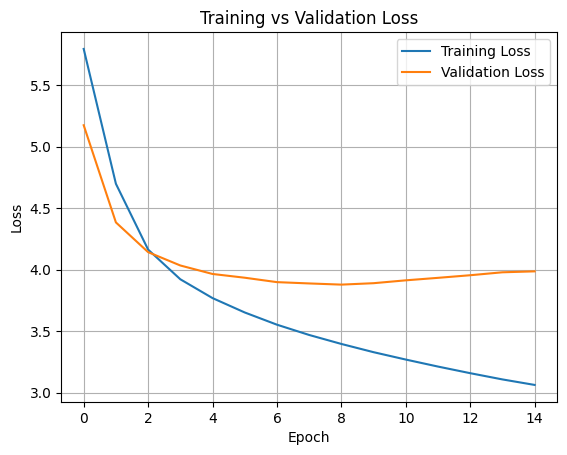

In [31]:
plt.plot(full_history['loss'], label='Training Loss')
plt.plot(full_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
# save the model
model.save('model.h5')

In [33]:
# Generate Captions for the image
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [34]:
# generate captions for the image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [35]:
# validate with text data
actual, predict = list(), list()

for key in tqdm(test):
  # get actual caption
  captions = mapping[key]
  # predict the caption for image
  y_pred = predict_caption(model, features[key], tokenizer, max_length)
  # split into words
  actual_captions = [caption.split() for caption in captions]
  y_pred = y_pred.split()
  # append to the list
  actual.append(actual_captions)
  predict.append(y_pred)

# calculate BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predict, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predict, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predict, weights=(0.33, 0.33, 0.33, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predict, weights=(0.25, 0.25, 0.25, 0.25)))


  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.419670
BLEU-2: 0.193288
BLEU-3: 0.108337
BLEU-4: 0.056702


In [36]:
# visualize the results
from PIL import Image
import matplotlib.pyplot as plt

In [37]:
def generate_captions(image_name):
    # load the img
    image_id = image_name.split('.')[0]
    img_path = os.path.join(extract_folders, 'Images', image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq brown dog chases the water from sprinkler on lawn endseq
startseq brown dog plays with the hose endseq
startseq brown dog running on lawn near garden hose endseq
startseq dog is playing with hose endseq
startseq large brown dog running away from the sprinkler in the grass endseq
--------------------Predicted--------------------
startseq two dogs are running through grassy field endseq


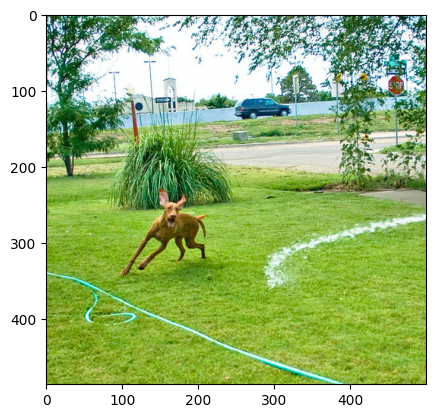

In [36]:
generate_captions('1019077836_6fc9b15408.jpg')

---------------------Actual---------------------
startseq people are riding around on snowmobiles endseq
startseq people pose with helmets and goggles on while riding snowmobiles endseq
startseq several people are taking break while on snowmobiling ride endseq
startseq three people and two snowmobiles endseq
startseq two helmeted men sit on yellow snowmobiles while another man stands behind watching endseq
--------------------Predicted--------------------
startseq man in blue shirt is standing on the ground by the man in the blue shirt and white helmet endseq


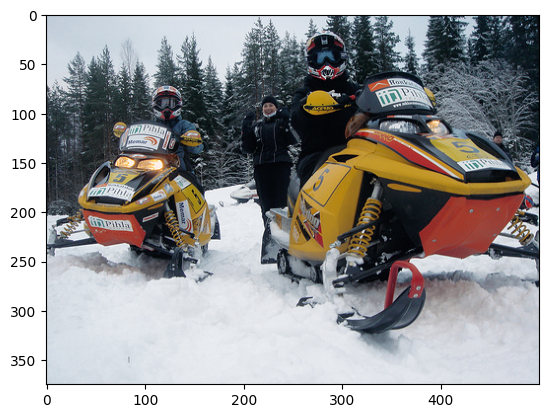

In [37]:
generate_captions('109738916_236dc456ac.jpg')

---------------------Actual---------------------
startseq child and woman are at waters edge in big city endseq
startseq large lake with lone duck swimming in it with several people around the edge of it endseq
startseq little boy at lake watching duck endseq
startseq young boy waves his hand at the duck in the water surrounded by green park endseq
startseq "two people are at the edge of lake endseq
--------------------Predicted--------------------
startseq man in blue shirt is standing on the ground by the ocean endseq


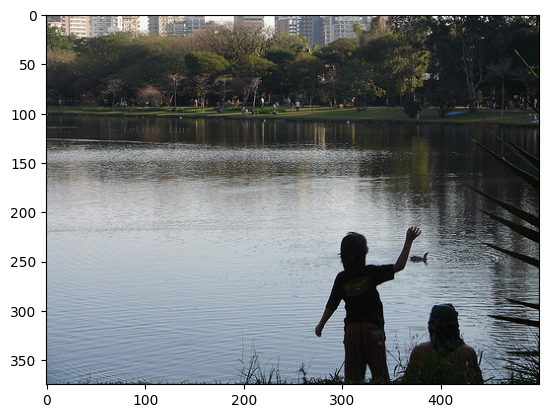

In [38]:
generate_captions('1022454332_6af2c1449a.jpg')

---------------------Actual---------------------
startseq people sit on the mountainside and check out the view endseq
startseq three people are on hilltop overlooking green valley endseq
startseq three people hang out on top of big hill endseq
startseq three people overlook green valley endseq
startseq three people rest on ledge above the moutains endseq
--------------------Predicted--------------------
startseq man in blue shirt is riding bike down dirt road endseq


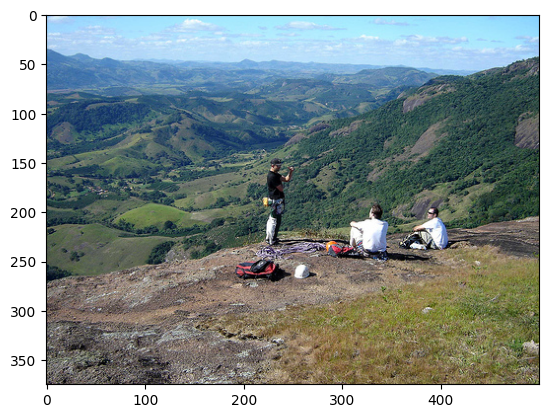

In [39]:
generate_captions('104136873_5b5d41be75.jpg')

---------------------Actual---------------------
startseq group of eight people are gathered around table at night endseq
startseq group of people gathered around in the dark endseq
startseq group of people sit around table outside on porch at night endseq
startseq group of people sit outdoors together at night endseq
startseq group of people sitting at table in darkened room endseq
--------------------Predicted--------------------
startseq two men are sitting on the ground endseq


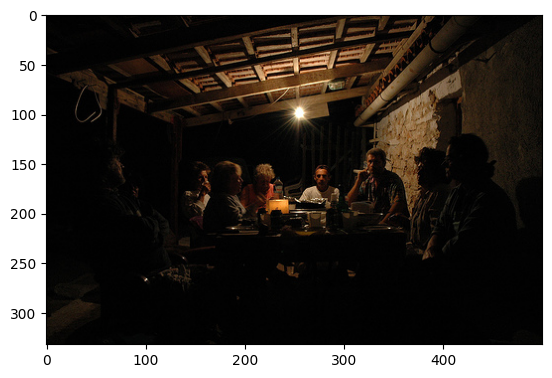

In [40]:
generate_captions('107582366_d86f2d3347.jpg')

In [39]:
# making the model as a function to test hyperparameter
def build_4096_model(vocab_size, max_length, embedding_dim=256, lstm_units=256, learning_rate=1e-3):
    # Image feature input
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.4)(inputs1)
    fe2 = Dense(lstm_units, activation='relu')(fe1)

    # Caption sequence input
    inputs2 = Input(shape=(max_length,))
    seq1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
    seq2 = Dropout(0.4)(seq1)
    seq3 = LSTM(lstm_units, return_sequences=False, recurrent_activation='sigmoid', activation='tanh', unroll=True)(seq2)

    # Decoder merge
    decoder1 = add([fe2, seq3])
    decoder2 = Dense(lstm_units, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # Define and compile model
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate))

    return model


# K-Fold Corss Validation

In [42]:
# Initialize KFold with 3 splits
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [ ]:
image_ids = list(mapping.keys())  # Use image IDs
fold = 1
losses = []

# Initialize the list to track the history of losses
full_history = {
    'loss': [],
    'val_loss': []
}

# Loop through the KFold splits
for train_index, val_index in kf.split(image_ids):
    print(f"\nFold {fold}")

    # Split data into train and validation sets
    train_ids = [image_ids[i] for i in train_index if image_ids[i] in features]
    val_ids = [image_ids[i] for i in val_index if image_ids[i] in features]

    # Set up data generators for this fold
    train_generator = datagenerator(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size=32)
    val_generator = datagenerator(val_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size=32)

    # Build the model for each fold (to reset weights for each fold)
    model = build_4096_model(vocab_size, max_length, embedding_dim=256, lstm_units=256, learning_rate=1e-3)

    # Calculate steps for the current fold
    steps = len(train_ids) // 32
    val_steps = len(val_ids) // 32

    # Train the model for 1 epoch for this fold
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=1,
        steps_per_epoch=steps,
        validation_steps=val_steps,
        verbose=1
    )


    # Append fold results to the history
    full_history['loss'] += history.history.get('loss', [])
    full_history['val_loss'] += history.history.get('val_loss', [])

    # Calculate the loss for this fold
    fold_loss = history.history['loss'][-1]
    losses.append(fold_loss)

    print(f"Fold {fold} Loss: {fold_loss:.4f}")
    fold += 1

# Calculate average loss across all folds
avg_loss = np.mean(losses)
print(f"\nAverage Loss Across {k} Folds: {avg_loss:.4f}")


Fold 1
202/202 ━━━━━━━━━━━━━━━━━━━━ 3362s 17s/step - loss: 5.9555 - val_loss: 4.5953
Fold 1 Loss: 5.3833

Fold 2
202/202 ━━━━━━━━━━━━━━━━━━━━ 2272s 11s/step - loss: 5.9650 - val_loss: 4.6342
Fold 2 Loss: 5.3728

Fold 3
202/202 ━━━━━━━━━━━━━━━━━━━━ 1919s 9s/step - loss: 5.9410 - val_loss: 4.5978
Fold 3 Loss: 5.3481

Fold 4
202/202 ━━━━━━━━━━━━━━━━━━━━ 1845s 9s/step - loss: 5.9716 - val_loss: 4.6201
Fold 4 Loss: 5.3925

Fold 5
192/202 ━━━━━━━━━━━━━━━━━━━━ 1:15 8s/step - loss: 6.0356

# Hyper parameter tunning

In [ ]:
embedding_dims = [128, 256]
lstm_units_list = [128, 256]
learning_rates = [1e-3, 1e-4]

best_loss = float('inf')
best_config = None

for emb_dim in embedding_dims:
    for lstm_unit in lstm_units_list:
        for lr in learning_rates:
            print(f"\nTesting: Emb={emb_dim}, LSTM={lstm_unit}, LR={lr}")
            model = build_4096_model(vocab_size, max_length, emb_dim, lstm_unit, lr)
            generator = datagenerator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size=32)
            steps = len(train) // 32
            history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=0)
            loss = history.history['loss'][0]

            print(f"Loss: {loss:.4f}")
            if loss < best_loss:
                best_loss = loss
                best_config = (emb_dim, lstm_unit, lr)

print("\nBest Config:")
print(f"Embedding: {best_config[0]}, LSTM: {best_config[1]}, LR: {best_config[2]}")



Testing: Emb=128, LSTM=128, LR=0.001
Loss: 5.6448

Testing: Emb=128, LSTM=128, LR=0.0001
Loss: 6.3482

Testing: Emb=128, LSTM=256, LR=0.001
Loss: 5.5073

Testing: Emb=128, LSTM=256, LR=0.0001
Loss: 6.1958

Testing: Emb=256, LSTM=128, LR=0.001
Loss: 5.5615

Testing: Emb=256, LSTM=128, LR=0.0001
